In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.special import expit
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical

In [2]:
class FCNN():
    '''
    Fully Connected Neural Network

    layer_sizes: list of number of neurons in each layer, including input and output.
    lr: learning rate hyperparameter
    beta: momentum hyperparameter
    activation_name: Activation function, either sigmoid or relu
    optimizer_name: Gradient Descent Optimization algorithm, either SGD or momentum
    '''
    def __init__(self, layer_sizes, lr = 0.001, beta = 0.9, activation_name = 'sigmoid',
                 optimizer_name = 'SGD'):
        self.layer_sizes = layer_sizes
        self.number_layers = len(self.layer_sizes)
        self.lr = lr
        self.beta = beta
        
        # Dictionary that will hold past epoch update to parameters
        # utilized in the momentum gradient descent
        # key is the name of the parameters, value is the update
        self.past_update = {} 
        
        # Initialize the weights and biases
        self.parameters = self.initialize_parameters()
        
        # Define the activation function of the hidden layers
        self.activation, self.der_activation = self.set_activation(activation_name)
        
        # Define the optimization gradient descent algorithm
        self.optimizer = self.set_optimizer(optimizer_name)
        
        # Save accuracy at each epoch
        self.accuracies = []
    
    # Define activation function and derivative
    def set_activation(self, activation_name):
        if activation_name == 'sigmoid':
            def activation(x):
                return self.sigmoid(x)
            def der_activation(x):
                return self.der_sigmoid(x)
            
        elif activation_name == 'relu':
            def activation(x):
                return self.relu(x)
            def der_activation(x):
                return self.der_relu(x)
        
        return activation, der_activation
    
    # Define optimizer
    def set_optimizer(self, optimizer_name):
        if optimizer_name == 'SGD':
            def optimizer(grad_w, grad_b):
                return self.SGD_update(grad_w, grad_b)
        elif optimizer_name == 'momentum':
            def optimizer(grad_w, grad_b):
                return self.momentum_update(grad_w, grad_b)
        
        return optimizer
    
    # Initialize weights and biases
    def initialize_parameters(self):
        parameters = {}
        for i in range(1, self.number_layers):
            #Initializing each parameters according to a standard normal distribution
            parameters['W'+str(i)] = np.random.randn(self.layer_sizes[i],
                                                     self.layer_sizes[i-1])
            parameters['b'+str(i)] = np.random.randn(self.layer_sizes[i])
        
        return parameters
            
    # Sigmoid activation function    
    def sigmoid(self, x):
        # Using scipy.specials.expit() instead of 1/(1+np.exp(-x))
        # to avoid overflow
        return expit(x)
    
    # Derivative of the sigmoid
    def der_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    # Rectified Linear unit activation function
    def relu(self, x):
        return np.maximum(0, x)
    
    # Derivative of the relu
    def der_relu(self, x):
        return 1 * (x > np.array(0))
    
    # Softmax activation function
    def softmax(self, x):
        # Avoiding underflow or overflow errors
        # by subtracting x.max()
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)
    
    # Derivative softmax function
    def der_softmax(self, x):
        # Avoiding underflow or overflow errors due to floating point instability:
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        
    # Forward propagation algorithm
    # Here we save the activations and Z to use in backpropagation
    def forward_propagation(self, data):
        inp = data
        self.parameters['A0'] = inp
        
        for i in range(1, self.number_layers):
            weights, bias = self.parameters['W'+str(i)], self.parameters['b'+str(i)]
            # Taking product of weights and input and adding bias
            self.parameters['Z'+str(i)] = np.dot(weights, inp) + bias
            
            if i != self.number_layers - 1:
                # Perform activation
                self.parameters['A'+ str(i)] = inp = \
                self.activation(self.parameters['Z'+str(i)])
            else:
                # If it is the last layer, apply softmax activation
                self.parameters['A'+ str(i)] = output = \
                self.softmax(self.parameters['Z'+str(i)])
        
        return output
            
    # Backpropagation algorithm
    def backward_propagation(self, output, y_train):
        # Save the gradient for each parameter
        grad_w = {}
        grad_b = {}
        
        # Using Mean Squared Error loss
        error = 2 * (output - y_train) / output.shape[0] \
        * self.der_softmax(self.parameters['Z' + str(self.number_layers - 1)])
        
        # Saving gradient and loss of weights and biases of last layer
        grad_w['W'+str(self.number_layers - 1)] = \
        np.outer(error, self.parameters['A' + str(self.number_layers - 2)])
        grad_b['b'+str(self.number_layers - 1)] = error
        
        # Backward propagating derivatives to previous layers
        # Saving each gradient of the weights and biases.
        for i in range(self.number_layers - 1, 1, -1):
            error = np.dot(self.parameters['W'+str(i)].T, error) * \
            self.der_activation(self.parameters['Z'+str(i-1)])
            grad_w['W'+str(i-1)] = np.outer(error, self.parameters['A'+str(i-2)])
            grad_b['b'+str(i-1)] = error

        return grad_w, grad_b
    
    def SGD_update(self, grad_w, grad_b):
        #Update network parameters using Stochastic Gradient Descent.
        # parameter = parameter - learning rate * gradient
        for key, value in grad_w.items():
            self.parameters[key] -= self.lr * value
        
        for key, value in grad_b.items():
            self.parameters[key] -= self.lr * value
            
    def momentum_update(self, grad_w, grad_b):
        # Update network parameters using Gradient Descent with momentum
        
        # Add keys to dictionary if it is empty
        # It will save the previous update of each parameter
        if not self.past_update:
            for key, value in grad_w.items():
                self.past_update[key] = np.zeros(value.shape)
            for key, value in grad_b.items():
                self.past_update[key] = np.zeros(value.shape)
    
    
        for key, value in grad_w.items():
            # Update value of previous epoch for the parameter
            v = self.past_update[key]
            # Calculate new update based on momentum formula
            update = self.beta * v + (1 - self.beta) * value
            # Update parameter
            self.parameters[key] -= self.lr * update
            # Save update amount to utilize in next update
            self.past_update[key] = update
        
        for key, value in grad_b.items():
            v = self.past_update[key]
            update = self.beta * v + (1 - self.beta) * value
            self.parameters[key] -= self.lr * update
            self.past_update[key] = update
    
    # Calculate accuracy for dataset
    def accuracy(self, x, y):
        predictions = []
        for xi, yi in zip(x, y):
            # Calculate network output for each x
            output = self.forward_propagation(xi)
            pred = np.argmax(output)
            # Check if it is correct
            predictions.append(pred == np.argmax(yi))
        
        return np.mean(predictions)
    
    # Training
    def train(self, x_train, y_train, x_test, y_test, epochs):
        start_time = time.time()
        # For each epoch
        for i in range(epochs):
            # For each data point
            for x,y in zip(x_train, y_train):
                # Calculate network output bt forward propagation
                output = self.forward_propagation(x)
                # Calculate gradients based on output by back propagation
                grad_w, grad_b = self.backward_propagation(output, y)
                # Update network parameters
                self.optimizer(grad_w, grad_b)
            
            # compute and save accuracy
            accuracy = self.accuracy(x_test, y_test)
            self.accuracies.append(accuracy)
            print(f'Epoch: {i}, Elapsed Time: {time.time() - start_time:.2f}s, Accuracy: {accuracy:.2f}')

## Training and Results

### MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = np.array([x.flatten() for x in X_train])
X_test = np.array([x.flatten() for x in X_test])

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [4]:
# Using Stochastic gradient descent
net1 = FCNN(layer_sizes = [784, 200, 80, 10], lr = 0.01, optimizer_name = 'SGD')
net1.train(X_train, Y_train, X_test, Y_test, 15)

Epoch: 0, Elapsed Time: 43.88s, Accuracy: 0.25
Epoch: 1, Elapsed Time: 87.80s, Accuracy: 0.39
Epoch: 2, Elapsed Time: 131.72s, Accuracy: 0.48
Epoch: 3, Elapsed Time: 175.69s, Accuracy: 0.56
Epoch: 4, Elapsed Time: 219.61s, Accuracy: 0.62
Epoch: 5, Elapsed Time: 263.63s, Accuracy: 0.65
Epoch: 6, Elapsed Time: 307.74s, Accuracy: 0.69
Epoch: 7, Elapsed Time: 352.56s, Accuracy: 0.71
Epoch: 8, Elapsed Time: 396.65s, Accuracy: 0.73
Epoch: 9, Elapsed Time: 450.63s, Accuracy: 0.74
Epoch: 10, Elapsed Time: 507.62s, Accuracy: 0.75
Epoch: 11, Elapsed Time: 564.44s, Accuracy: 0.76
Epoch: 12, Elapsed Time: 621.30s, Accuracy: 0.77
Epoch: 13, Elapsed Time: 679.12s, Accuracy: 0.78
Epoch: 14, Elapsed Time: 736.06s, Accuracy: 0.79


In [5]:
# Using Momentum gradient descent
net2 = FCNN(layer_sizes = [784, 200, 80, 10], lr = 0.01, optimizer_name = 'momentum')
net2.train(X_train, Y_train, X_test, Y_test, 15)

Epoch: 0, Elapsed Time: 126.93s, Accuracy: 0.24
Epoch: 1, Elapsed Time: 254.73s, Accuracy: 0.40
Epoch: 2, Elapsed Time: 371.13s, Accuracy: 0.50
Epoch: 3, Elapsed Time: 529.35s, Accuracy: 0.56
Epoch: 4, Elapsed Time: 649.33s, Accuracy: 0.60
Epoch: 5, Elapsed Time: 758.84s, Accuracy: 0.64
Epoch: 6, Elapsed Time: 900.05s, Accuracy: 0.67
Epoch: 7, Elapsed Time: 1058.19s, Accuracy: 0.68
Epoch: 8, Elapsed Time: 1213.27s, Accuracy: 0.70
Epoch: 9, Elapsed Time: 1363.04s, Accuracy: 0.72
Epoch: 10, Elapsed Time: 1474.79s, Accuracy: 0.74
Epoch: 11, Elapsed Time: 1601.22s, Accuracy: 0.75
Epoch: 12, Elapsed Time: 1742.54s, Accuracy: 0.76
Epoch: 13, Elapsed Time: 1848.40s, Accuracy: 0.78
Epoch: 14, Elapsed Time: 1989.59s, Accuracy: 0.78


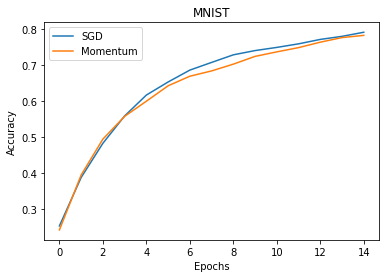

In [6]:
plt.plot(np.arange(0,15), net1.accuracies, label = 'SGD')
plt.plot(np.arange(0,15), net2.accuracies, label = 'Momentum')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST')
plt.legend()
plt.show()

### CIFAR10

In [7]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train = np.array([x.flatten() for x in X_train])
X_test = np.array([x.flatten() for x in X_test])

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [8]:
# Using Stochastic gradient descent
net3 = FCNN(layer_sizes = [3072, 384, 128, 10], lr = 0.01, optimizer_name = 'SGD')
net3.train(X_train, Y_train, X_test, Y_test, 5)

Epoch: 0, Elapsed Time: 421.93s, Accuracy: 0.10
Epoch: 1, Elapsed Time: 868.91s, Accuracy: 0.10
Epoch: 2, Elapsed Time: 1203.17s, Accuracy: 0.10
Epoch: 3, Elapsed Time: 1520.83s, Accuracy: 0.11
Epoch: 4, Elapsed Time: 1838.02s, Accuracy: 0.14


In [9]:
# Using Momentum gradient descent
net4 = FCNN(layer_sizes = [3072, 384, 128, 10], lr = 0.01, optimizer_name = 'momentum')
net4.train(X_train, Y_train, X_test, Y_test, 5)

Epoch: 0, Elapsed Time: 771.84s, Accuracy: 0.12
Epoch: 1, Elapsed Time: 1600.63s, Accuracy: 0.11
Epoch: 2, Elapsed Time: 2447.93s, Accuracy: 0.11
Epoch: 3, Elapsed Time: 3197.28s, Accuracy: 0.11
Epoch: 4, Elapsed Time: 3942.31s, Accuracy: 0.11


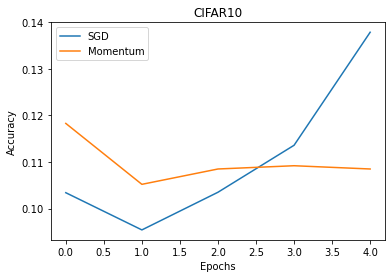

In [10]:
plt.plot(np.arange(0,5), net3.accuracies,  label = 'SGD')
plt.plot(np.arange(0,5), net4.accuracies, label = 'Momentum')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CIFAR10')
plt.legend()
plt.show()

## Summary
The neural network can train and improve on the MNIST dataset. Both Stochastic Gradient Descent and Momentum Gradient Descent obtained almost 80% accuracy after 15 epochs. While on the CIFAR10 dataset, they did not show much improvement in the first 5 epochs. Likely because of the architecture of the network and the amount of training it went through. It has only two hidden layers of size 384 and 128, while the input is of size 3072 (32x32x3), so the network is probably not able to represent and learn the features of the images. A more complex network might obtain better accuracy, but it would also take too long to train.  

The positive aspect of this Neural Network is that it is versatile. One can determine the number of layers and neurons on each layer. Thus it can efficiently be utilized on different datasets. It is also possible to change the activation function between sigmoid and ReLU and the optimization method between SGD with and without Momentum. Implementing new activations and optimizers should also be simple, given that all one has to do is define them on the set_activation and set_optimizer methods. The optimizer might have some hyperparameters that also need to be included in the initialization.  

The negative aspect of this Neural Network is the time complexity. It updates the weights of the network for each datapoint, which results in a long training time. It could have been faster if it utilized batch or mini-batch gradient descent, so the weights would be updated less, resulting on it running faster. It also does not allow one to customize the hidden layers fully. All the hidden layers utilize the same activation function.